In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

Load Dataset

In [ ]:
# Load datasets
outbreak_data = pd.read_csv('/content/disease_outbreak_data.csv')
hospital_data = pd.read_csv('/content/synthetic_hospital_readmissions_data.csv')

# Merge datasets on a common key (assuming 'region_id' and 'Patient_ID' are related)
data = pd.merge(outbreak_data, hospital_data, left_on='region_id', right_on='Patient_ID', how='inner')

# Drop unnecessary columns after merging
data.drop(columns=['Patient_ID'], inplace=True)

# Display dataset information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   region_id                       9999 non-null   int64  
 1   region_type                     9999 non-null   object 
 2   population_density              9999 non-null   float64
 3   median_income                   9999 non-null   float64
 4   elderly_percentage              9999 non-null   float64
 5   child_percentage                9999 non-null   float64
 6   hospitals_per_100k              9999 non-null   float64
 7   vaccination_rate                9499 non-null   float64
 8   healthcare_accessibility_score  9499 non-null   float64
 9   avg_temperature                 9999 non-null   float64
 10  avg_humidity                    9999 non-null   float64
 11  annual_rainfall                 9999 non-null   float64
 12  air_quality_index               99

In [ ]:
outbreak_data.tail()

,region_id,region_type,population_density,median_income,elderly_percentage,child_percentage,hospitals_per_100k,vaccination_rate,healthcare_accessibility_score,avg_temperature,...,annual_rainfall,air_quality_index,disease_incidents_last_year,outbreak_frequency_5years,avg_outbreak_duration,daily_commuter_percentage,international_travel_freq,public_transport_usage,risk_score,outbreak_risk_category
9995,9995,Suburban,604.578638,69777.578677,20.999746,21.117776,2.285226,0.605561,0.573275,19.048404,...,1011.543728,148.313369,87,8,22.200592,32.928318,3.017903,11.411833,47.611524,Medium Risk
9996,9996,Suburban,1742.541805,32361.655154,10.700479,19.267828,2.076407,0.716746,0.691871,17.007391,...,1163.556271,146.630133,102,1,24.210114,55.865822,4.279763,39.368211,42.864102,Medium Risk
9997,9997,Rural,409.219976,44412.254477,10.307170,16.860258,0.808470,0.663049,0.793505,8.054553,...,1533.642285,123.460405,100,6,18.740132,54.270234,0.895611,37.706296,39.190095,Medium Risk
9998,9998,Rural,130.823003,43109.431704,26.163805,19.647374,0.966565,NaN,0.805805,15.315754,...,1207.943007,74.589373,96,4,23.074579,51.361708,2.638970,17.599249,34.986515,Medium Risk
9999,9999,Rural,143.175027,66136.610363,19.245840,23.391001,1.007851,0.544468,0.751546,24.127911,...,1602.738124,89.259934,104,0,23.747894,28.275489,0.550018,49.279774,32.280313,Medium Risk


In [ ]:
hospital_data.tail()

,Patient_ID,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
9995,9996,61,Other,Urgent,Injury,32,7,3,2,2,1,Normal,No
9996,9997,45,Male,Urgent,Heart Disease,28,9,3,3,0,2,Abnormal,No
9997,9998,19,Male,Elective,Injury,56,22,3,1,1,1,Normal,No
9998,9999,74,Female,Elective,Injury,4,10,4,3,3,3,Abnormal,Yes
9999,10000,74,Male,Elective,Infection,8,1,1,1,2,9,NaN,Yes


In [ ]:
data.columns

Index(['region_id', 'region_type', 'population_density', 'median_income',
       'elderly_percentage', 'child_percentage', 'hospitals_per_100k',
       'vaccination_rate', 'healthcare_accessibility_score', 'avg_temperature',
       'avg_humidity', 'annual_rainfall', 'air_quality_index',
       'disease_incidents_last_year', 'outbreak_frequency_5years',
       'avg_outbreak_duration', 'daily_commuter_percentage',
       'international_travel_freq', 'public_transport_usage', 'risk_score',
       'outbreak_risk_category', 'Age', 'Gender', 'Admission_Type',
       'Diagnosis', 'Num_Lab_Procedures', 'Num_Medications',
       'Num_Outpatient_Visits', 'Num_Inpatient_Visits', 'Num_Emergency_Visits',
       'Num_Diagnoses', 'A1C_Result', 'Readmitted'],
      dtype='object')

Handle missing values

In [ ]:
# Separate numeric and categorical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Fill missing values for numeric columns with the mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing values for categorical columns with the mode
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

Encoding categorical variables

In [ ]:
# Encode categorical variables using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    if col in data.columns:
        data[col] = le.fit_transform(data[col])

# Ensure target variable is categorical
data['outbreak_risk_category'] = data['outbreak_risk_category'].astype('category')

In [ ]:
data.head()

,region_id,region_type,population_density,median_income,elderly_percentage,child_percentage,hospitals_per_100k,vaccination_rate,healthcare_accessibility_score,avg_temperature,...,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
0,1,1,1099.791458,46234.340479,22.367720,18.824620,2.974846,0.693353,0.829970,19.180664,...,2,0,35,14,2,1,4,5,1,0
1,2,2,5961.415281,62338.173682,16.234222,20.200680,3.866776,0.686971,0.884792,13.895782,...,1,2,66,3,1,2,4,6,1,0
2,3,0,274.449145,56912.244502,22.140685,17.759992,0.796274,0.533053,0.407818,20.429617,...,0,0,22,2,4,3,3,5,0,1
3,4,1,643.115175,72034.119281,23.318447,20.912978,1.912083,0.712249,0.591463,14.380508,...,2,2,22,10,2,2,3,9,1,1
4,5,0,242.931409,76914.212645,12.786629,21.044174,1.039841,0.540612,0.871427,22.903448,...,1,1,3,6,4,3,1,2,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Normalize numerical data
scaler = StandardScaler()
numerical_columns = ['population_density', 'median_income', 'vaccination_rate', 'avg_temperature',
                     'hospitals_per_100k', 'healthcare_accessibility_score', 'annual_rainfall', 'air_quality_index']

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Check the cleaned data
print(data.head())

   region_id  region_type  population_density  median_income  \
0          1            1           -0.458463      -0.252188   
1          2            2            1.342998       0.825290   
2          3            0           -0.764292       0.462251   
3          4            1           -0.627683       1.474029   
4          5            0           -0.775970       1.800547   

   elderly_percentage  child_percentage  hospitals_per_100k  vaccination_rate  \
0           22.367720         18.824620            0.555913          0.104861   
1           16.234222         20.200680            1.311902          0.026129   
2           22.140685         17.759992           -1.290620         -1.872783   
3           23.318447         20.912978           -0.344873          0.337987   
4           12.786629         21.044174           -1.084175         -1.779528   

   healthcare_accessibility_score  avg_temperature  ...  Admission_Type  \
0                        1.285971        -0.169130  .

Kmeans clustering region based on population density and vacination rate

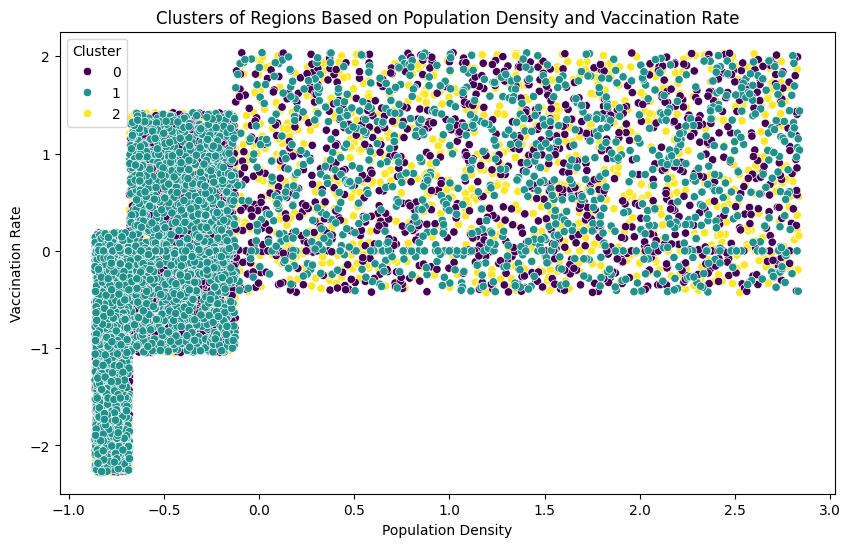

In [ ]:
# Select features for clustering (excluding target variables)
clustering_features = data.drop(columns=['outbreak_risk_category'])
from sklearn.cluster import KMeans
# Apply K-means clustering with optimal clusters (e.g., 3 based on elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(clustering_features)

# Visualize clusters based on two key features (e.g., population density and vaccination rate)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['population_density'], y=data['vaccination_rate'], hue=data['cluster'], palette='viridis')
plt.title('Clusters of Regions Based on Population Density and Vaccination Rate')
plt.xlabel('Population Density')
plt.ylabel('Vaccination Rate')
plt.legend(title='Cluster')
plt.show()

CLustering regions by Risk Level and Validation of Clusters

K-Means Silhouette Score: 0.14


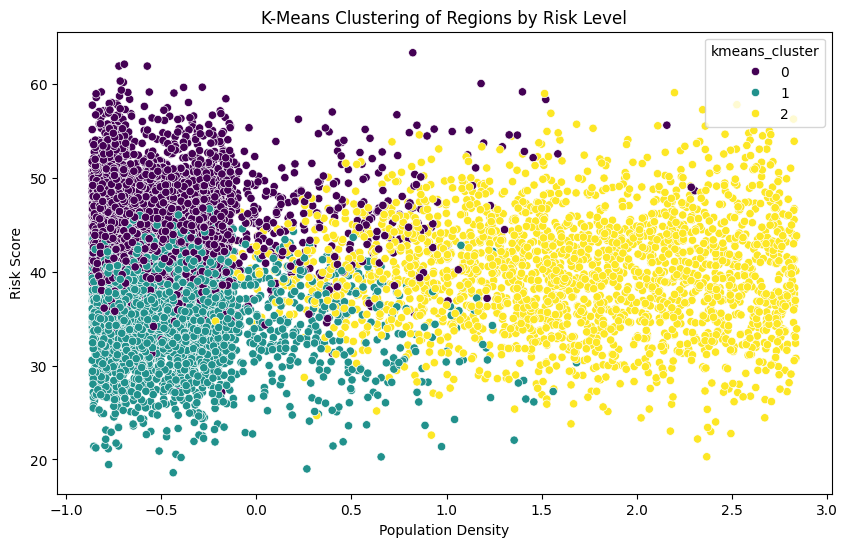

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select features for clustering
features = data[[
    "population_density",
    "median_income",
    "elderly_percentage",
    "vaccination_rate",
    "healthcare_accessibility_score",
    "air_quality_index",
    "risk_score"
]].dropna()  # Drop rows with missing values

# Step 2: Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 3: Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data["kmeans_cluster"] = kmeans.fit_predict(scaled_features)

# Step 5: Evaluate K-Means using silhouette score
silhouette_avg = silhouette_score(scaled_features, data["kmeans_cluster"])
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")

# Visualize K-Means Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=features["population_density"],
    y=features["risk_score"],
    hue=data["kmeans_cluster"],
    palette="viridis"
)
plt.title("K-Means Clustering of Regions by Risk Level")
plt.xlabel("Population Density")
plt.ylabel("Risk Score")
plt.show()

<ipython-input-9-354875e3c132>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group1_data.index, y=group1_data.values, ax=axes[0], palette="Blues_d")
<ipython-input-9-354875e3c132>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group2_data.index, y=group2_data.values, ax=axes[1], palette="Greens_d")


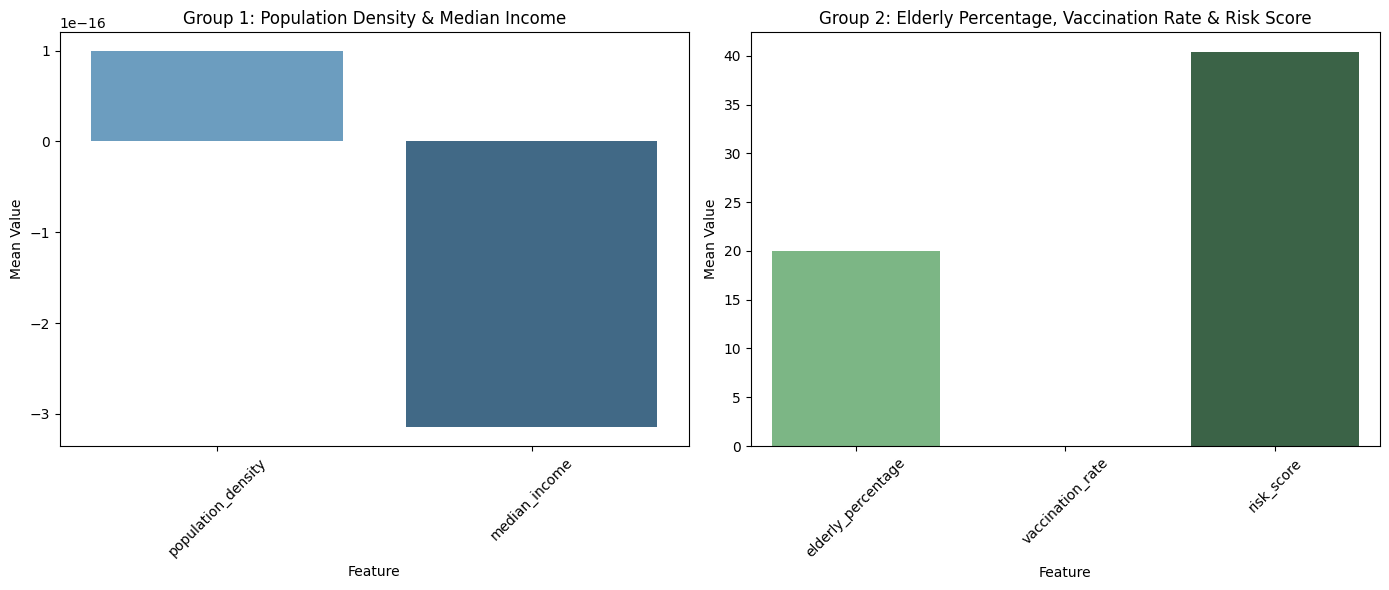

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame (replace this with your actual data)
# Let's assume 'data' is the DataFrame you are working with

# Grouping the features into two sets
group1_features = ['population_density', 'median_income']
group2_features = ['elderly_percentage', 'vaccination_rate', 'risk_score']

# Create the figure and subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Group 1
group1_data = data[group1_features].mean()  # Mean value for each feature in group 1
sns.barplot(x=group1_data.index, y=group1_data.values, ax=axes[0], palette="Blues_d")
axes[0].set_title("Group 1: Population Density & Median Income")
axes[0].set_ylabel("Mean Value")
axes[0].set_xlabel("Feature")
axes[0].tick_params(axis='x', rotation=45)

# Plot for Group 2
group2_data = data[group2_features].mean()  # Mean value for each feature in group 2
sns.barplot(x=group2_data.index, y=group2_data.values, ax=axes[1], palette="Greens_d")
axes[1].set_title("Group 2: Elderly Percentage, Vaccination Rate & Risk Score")
axes[1].set_ylabel("Mean Value")
axes[1].set_xlabel("Feature")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Features Importance-Apply Random Forest

Feature Importances:
                           Feature  Importance
19                      risk_score    0.675164
17       international_travel_freq    0.049422
10                    avg_humidity    0.038839
12               air_quality_index    0.035382
14       outbreak_frequency_5years    0.032730
18          public_transport_usage    0.019400
8   healthcare_accessibility_score    0.014062
16       daily_commuter_percentage    0.010766
33                  kmeans_cluster    0.009863
7                 vaccination_rate    0.008947
4               elderly_percentage    0.008311
5                 child_percentage    0.007726
9                  avg_temperature    0.007380
2               population_density    0.007320
11                 annual_rainfall    0.007095
0                        region_id    0.007031
6               hospitals_per_100k    0.006991
24              Num_Lab_Procedures    0.006699
15           avg_outbreak_duration    0.006471
3                    median_income    0

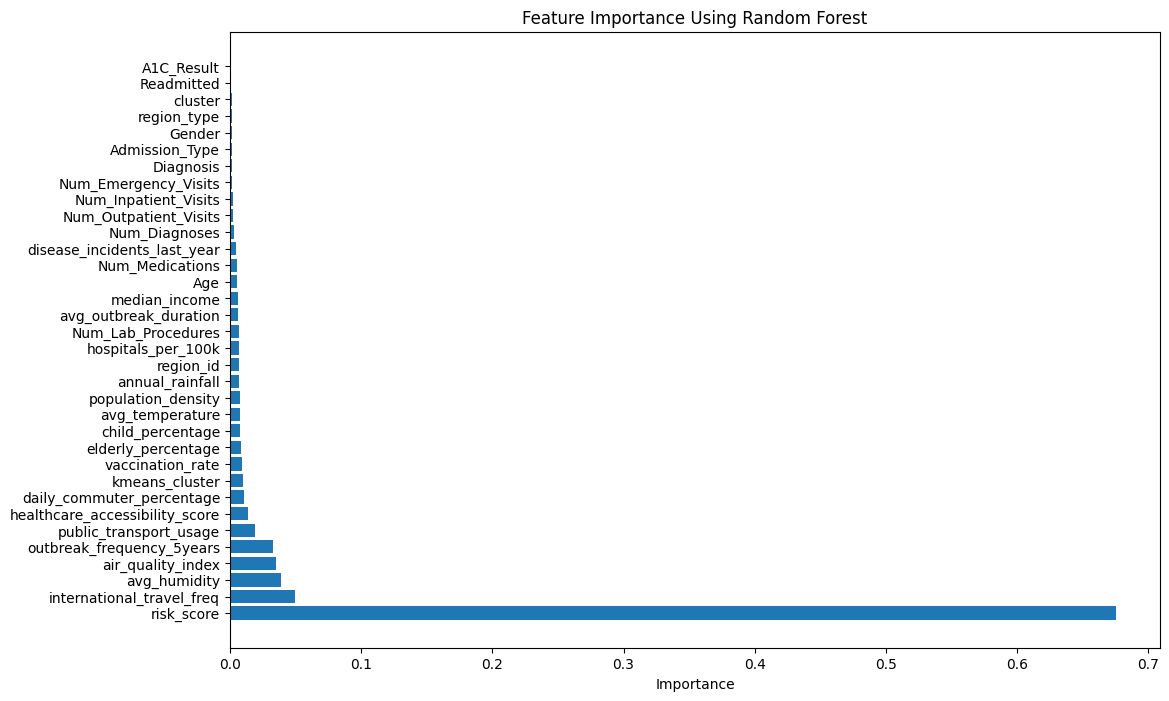

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Define the feature matrix X and target vector y
X = data.drop(columns=['outbreak_risk_category'])  # Drop target column
y = data['outbreak_risk_category']  # Target column

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their corresponding importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the most important features
print("Feature Importances:")
print(feature_importance_df)

# Optionally, plot the feature importances for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance Using Random Forest')
plt.show()

In [ ]:
# Display the most important features sorted by their importance
important_features = feature_importance_df[['Feature', 'Importance']].head(10)  # Show top 10 important features

print("Top 10 Important Features for Model Training:")
print(important_features)

Top 10 Important Features for Model Training:
                           Feature  Importance
19                      risk_score    0.675164
17       international_travel_freq    0.049422
10                    avg_humidity    0.038839
12               air_quality_index    0.035382
14       outbreak_frequency_5years    0.032730
18          public_transport_usage    0.019400
8   healthcare_accessibility_score    0.014062
16       daily_commuter_percentage    0.010766
33                  kmeans_cluster    0.009863
7                 vaccination_rate    0.008947


In [ ]:
print(data['outbreak_risk_category'])

0       2
1       2
2       2
3       2
4       2
       ..
9994    2
9995    2
9996    2
9997    2
9998    2
Name: outbreak_risk_category, Length: 9999, dtype: category
Categories (3, int64): [0, 1, 2]


Model Selection (Random Forest-classification with unbalnced class data)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define the feature matrix X and target vector y
X = data[['risk_score', 'international_travel_freq', 'avg_humidity',
          'air_quality_index', 'outbreak_frequency_5years',
          'public_transport_usage', 'healthcare_accessibility_score',
          'daily_commuter_percentage', 'kmeans_cluster', 'vaccination_rate']]
y = data['outbreak_risk_category']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the model (RandomForestClassifier as an example)
model = RandomForestClassifier(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score (for multi-class)
label_encoder = LabelEncoder()

# Encode the target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Calculate ROC-AUC score (multi-class)
roc_auc = roc_auc_score(y_test_encoded, model.predict_proba(X_test), multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate True Positives, False Positives, True Negatives, False Negatives
# Assuming a binary classification (adjust for multi-class accordingly)
TP = np.diag(conf_matrix)  # True Positives are on the diagonal
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives are column sums minus TP
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives are row sums minus TP
TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives are the remaining values

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

# For multi-class, you might want to print these for each class
for i in range(len(TP)):
    print(f"Class {label_encoder.inverse_transform([i])[0]}:")
    print(f"  True Positives: {TP[i]}")
    print(f"  False Positives: {FP[i]}")
    print(f"  False Negatives: {FN[i]}")
    print(f"  True Negatives: {TN[i]}")
    print()

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        85
           2       1.00      1.00      1.00      1914

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC Score: 1.0000
Confusion Matrix:
[[   1    0    0]
 [   0   85    0]
 [   0    0 1914]]
True Positives: [   1   85 1914]
False Positives: [0 0 0]
True Negatives: [1999 1915   86]
False Negatives: [0 0 0]
Class 0:
  True Positives: 1
  False Positives: 0
  False Negatives: 0
  True Negatives: 1999

Class 1:
  True Positives: 85
  False Positives: 0
  False Negatives: 0
  True Negatives: 1915

Class 2:
  True Positives: 1914
  False Positives: 0
  False Negatives: 0
  True Negatives: 86



Random Forest classification with balanced class data (Apply SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

#X = data.drop(columns=['outbreak_risk_category'])
X = data[['risk_score', 'international_travel_freq', 'avg_humidity',
          'air_quality_index', 'outbreak_frequency_5years',
          'public_transport_usage', 'healthcare_accessibility_score',
          'daily_commuter_percentage', 'kmeans_cluster', 'vaccination_rate']]
y = data['outbreak_risk_category']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate Random Forest Classifier performance
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(pd.get_dummies(y_test), rf_classifier.predict_proba(X_test), multi_class='ovr')
print(f"Random Forest ROC-AUC Score: {roc_auc_rf}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1881
           1       1.00      1.00      1.00      1885
           2       1.00      1.00      1.00      1907

    accuracy                           1.00      5673
   macro avg       1.00      1.00      1.00      5673
weighted avg       1.00      1.00      1.00      5673

Random Forest ROC-AUC Score: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import numpy as np

# Fit the Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate Random Forest Classifier performance
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Calculate ROC-AUC score for multi-class classification
roc_auc_rf = roc_auc_score(pd.get_dummies(y_test), rf_classifier.predict_proba(X_test), multi_class='ovr')
print(f"Random Forest ROC-AUC Score: {roc_auc_rf}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Print the confusion matrix
print("\nConfusion Matrix:")
print(cm)

# Initialize the lists to store metrics for each class
classes = np.unique(y_test)  # Unique classes (e.g., 0, 1, 2)

# Loop over each class and calculate the metrics
for i in classes:
    # True Positives: Diagonal elements
    tp = cm[i, i]

    # False Positives: Sum of the column minus the diagonal
    fp = cm[:, i].sum() - tp

    # False Negatives: Sum of the row minus the diagonal
    fn = cm[i, :].sum() - tp

    # True Negatives: Total elements minus TP, FP, and FN
    tn = cm.sum() - (tp + fp + fn)

    # Print metrics for each class
    print(f"\nClass {i}:")
    print(f"  True Positives: {tp}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print(f"  True Negatives: {tn}")

    # Optional: Calculate Precision, Recall, and F1-Score for each class
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1_score:.4f}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1881
           1       1.00      1.00      1.00      1885
           2       1.00      1.00      1.00      1907

    accuracy                           1.00      5673
   macro avg       1.00      1.00      1.00      5673
weighted avg       1.00      1.00      1.00      5673

Random Forest ROC-AUC Score: 1.0

Confusion Matrix:
[[1881    0    0]
 [   0 1885    0]
 [   0    0 1907]]

Class 0:
  True Positives: 1881
  False Positives: 0
  False Negatives: 0
  True Negatives: 3792
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Class 1:
  True Positives: 1885
  False Positives: 0
  False Negatives: 0
  True Negatives: 3788
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Class 2:
  True Positives: 1907
  False Positives: 0
  False Negatives: 0
  True Negatives: 3766
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000


MLP CLassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import numpy as np

# Define and train the MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Evaluate Neural Network Classifier performance
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# ROC-AUC Score (multi-class if necessary)
roc_auc_mlp = roc_auc_score(pd.get_dummies(y_test), mlp_classifier.predict_proba(X_test), multi_class='ovr')
print(f"Neural Network ROC-AUC Score: {roc_auc_mlp:.4f}")

# Calculate confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

# Create a DataFrame for easier visualization of the confusion matrix
conf_matrix_df_mlp = pd.DataFrame(conf_matrix_mlp,
                                   columns=[f"Predicted Class {i}" for i in range(len(conf_matrix_mlp))],
                                   index=[f"True Class {i}" for i in range(len(conf_matrix_mlp))])

print("Confusion Matrix (Detailed):")
print(conf_matrix_df_mlp)

# Extract TP, FP, TN, FN for each class
for i in range(len(conf_matrix_mlp)):
    TP = conf_matrix_mlp[i, i]
    FP = conf_matrix_mlp[:, i].sum() - TP
    FN = conf_matrix_mlp[i, :].sum() - TP
    TN = conf_matrix_mlp.sum() - (TP + FP + FN)

    print(f"Class {i}:")
    print(f"  True Positive (TP): {TP}")
    print(f"  False Positive (FP): {FP}")
    print(f"  False Negative (FN): {FN}")
    print(f"  True Negative (TN): {TN}")
    print(f"  Accuracy for Class {i}: {TP / (TP + FP + FN):.4f}")
    print("-" * 40)

# Optionally, calculate overall metrics like precision, recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

for i in range(len(conf_matrix_mlp)):
    precision = precision_score(y_test, y_pred_mlp, average=None)[i]
    recall = recall_score(y_test, y_pred_mlp, average=None)[i]
    f1 = f1_score(y_test, y_pred_mlp, average=None)[i]

    print(f"Class {i} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1881
           1       0.99      1.00      1.00      1885
           2       1.00      0.99      1.00      1907

    accuracy                           1.00      5673
   macro avg       1.00      1.00      1.00      5673
weighted avg       1.00      1.00      1.00      5673

Neural Network ROC-AUC Score: 0.9999
Confusion Matrix (Detailed):
              Predicted Class 0  Predicted Class 1  Predicted Class 2
True Class 0               1881                  0                  0
True Class 1                  0               1885                  0
True Class 2                  2                 12               1893
Class 0:
  True Positive (TP): 1881
  False Positive (FP): 2
  False Negative (FN): 0
  True Negative (TN): 3790
  Accuracy for Class 0: 0.9989
----------------------------------------
Class 1:
  True Positive (TP): 1885
  False Positi

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import numpy as np

# Define the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix_log_reg = confusion_matrix(y_test, y_pred)
print(conf_matrix_log_reg)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"Logistic Regression ROC-AUC Score: {roc_auc:.4f}")

# Detailed Confusion Matrix with TP, FP, TN, FN for each class
conf_matrix_df_log_reg = pd.DataFrame(conf_matrix_log_reg,
                                      columns=[f"Predicted Class {i}" for i in range(conf_matrix_log_reg.shape[1])],
                                      index=[f"True Class {i}" for i in range(conf_matrix_log_reg.shape[0])])

print("Detailed Confusion Matrix (TP, FP, TN, FN for each class):")
print(conf_matrix_df_log_reg)

# Extract TP, FP, TN, FN for each class and display them
for i in range(conf_matrix_log_reg.shape[0]):
    TP = conf_matrix_log_reg[i, i]
    FP = conf_matrix_log_reg[:, i].sum() - TP
    FN = conf_matrix_log_reg[i, :].sum() - TP
    TN = conf_matrix_log_reg.sum() - (TP + FP + FN)

    print(f"Class {i}:")
    print(f"  True Positive (TP): {TP}")
    print(f"  False Positive (FP): {FP}")
    print(f"  False Negative (FN): {FN}")
    print(f"  True Negative (TN): {TN}")
    print(f"  Accuracy for Class {i}: {TP / (TP + FP + FN):.4f}")
    print("-" * 40)

# Optionally, calculate overall metrics like precision, recall, and f1-score for each class
from sklearn.metrics import precision_score, recall_score, f1_score

for i in range(conf_matrix_log_reg.shape[0]):
    precision = precision_score(y_test, y_pred, average=None)[i]
    recall = recall_score(y_test, y_pred, average=None)[i]
    f1 = f1_score(y_test, y_pred, average=None)[i]

    print(f"Class {i} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1881
           1       1.00      1.00      1.00      1885
           2       1.00      0.99      1.00      1907

    accuracy                           1.00      5673
   macro avg       1.00      1.00      1.00      5673
weighted avg       1.00      1.00      1.00      5673

Confusion Matrix:
[[1881    0    0]
 [   0 1885    0]
 [   1    9 1897]]
Logistic Regression ROC-AUC Score: 0.9995
Detailed Confusion Matrix (TP, FP, TN, FN for each class):
              Predicted Class 0  Predicted Class 1  Predicted Class 2
True Class 0               1881                  0                  0
True Class 1                  0               1885                  0
True Class 2                  1                  9               1897
Class 0:
  True Positive (TP): 1881
  False Positive (FP): 1
  False Negative (FN): 0
  True Negative (TN): 3791
  Accuracy for Class 0: 0.999

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import numpy as np

# Define the Naive Bayes classifier
nb_model = GaussianNB()

# Train the model on the training set
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix_nb = confusion_matrix(y_test, y_pred)
print(conf_matrix_nb)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"Naive Bayes ROC-AUC Score: {roc_auc:.4f}")

# Detailed Confusion Matrix with TP, FP, TN, FN for each class
conf_matrix_df_nb = pd.DataFrame(conf_matrix_nb,
                                  columns=[f"Predicted Class {i}" for i in range(conf_matrix_nb.shape[1])],
                                  index=[f"True Class {i}" for i in range(conf_matrix_nb.shape[0])])

print("Detailed Confusion Matrix (TP, FP, TN, FN for each class):")
print(conf_matrix_df_nb)

# Extract TP, FP, TN, FN for each class and display them
for i in range(conf_matrix_nb.shape[0]):
    TP = conf_matrix_nb[i, i]
    FP = conf_matrix_nb[:, i].sum() - TP
    FN = conf_matrix_nb[i, :].sum() - TP
    TN = conf_matrix_nb.sum() - (TP + FP + FN)

    print(f"Class {i}:")
    print(f"  True Positive (TP): {TP}")
    print(f"  False Positive (FP): {FP}")
    print(f"  False Negative (FN): {FN}")
    print(f"  True Negative (TN): {TN}")
    print(f"  Accuracy for Class {i}: {TP / (TP + FP + FN):.4f}")
    print("-" * 40)

# Optionally, calculate overall metrics like precision, recall, and f1-score for each class
from sklearn.metrics import precision_score, recall_score, f1_score

for i in range(conf_matrix_nb.shape[0]):
    precision = precision_score(y_test, y_pred, average=None)[i]
    recall = recall_score(y_test, y_pred, average=None)[i]
    f1 = f1_score(y_test, y_pred, average=None)[i]

    print(f"Class {i} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1881
           1       0.95      0.98      0.96      1885
           2       0.98      0.95      0.96      1907

    accuracy                           0.97      5673
   macro avg       0.97      0.97      0.97      5673
weighted avg       0.97      0.97      0.97      5673

Confusion Matrix:
[[1881    0    0]
 [   0 1839   46]
 [   3   95 1809]]
Naive Bayes ROC-AUC Score: 0.9974
Detailed Confusion Matrix (TP, FP, TN, FN for each class):
              Predicted Class 0  Predicted Class 1  Predicted Class 2
True Class 0               1881                  0                  0
True Class 1                  0               1839                 46
True Class 2                  3                 95               1809
Class 0:
  True Positive (TP): 1881
  False Positive (FP): 3
  False Negative (FN): 0
  True Negative (TN): 3789
  Accuracy for Class 0: 0.9984
------

KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# Define the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training set
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix_knn = confusion_matrix(y_test, y_pred)
print(conf_matrix_knn)

# Detailed Confusion Matrix with TP, FP, TN, FN for each class
conf_matrix_df_knn = pd.DataFrame(conf_matrix_knn,
                                   columns=[f"Predicted Class {i}" for i in range(conf_matrix_knn.shape[1])],
                                   index=[f"True Class {i}" for i in range(conf_matrix_knn.shape[0])])

print("Detailed Confusion Matrix (TP, FP, TN, FN for each class):")
print(conf_matrix_df_knn)

# Extract TP, FP, TN, FN for each class and display them
for i in range(conf_matrix_knn.shape[0]):
    TP = conf_matrix_knn[i, i]
    FP = conf_matrix_knn[:, i].sum() - TP
    FN = conf_matrix_knn[i, :].sum() - TP
    TN = conf_matrix_knn.sum() - (TP + FP + FN)

    print(f"Class {i}:")
    print(f"  True Positive (TP): {TP}")
    print(f"  False Positive (FP): {FP}")
    print(f"  False Negative (FN): {FN}")
    print(f"  True Negative (TN): {TN}")
    print(f"  Accuracy for Class {i}: {TP / (TP + FP + FN):.4f}")
    print("-" * 40)

# Optionally, calculate overall metrics like precision, recall, and f1-score for each class
from sklearn.metrics import precision_score, recall_score, f1_score

for i in range(conf_matrix_knn.shape[0]):
    precision = precision_score(y_test, y_pred, average=None)[i]
    recall = recall_score(y_test, y_pred, average=None)[i]
    f1 = f1_score(y_test, y_pred, average=None)[i]

    print(f"Class {i} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1881
           1       0.96      1.00      0.98      1885
           2       1.00      0.96      0.98      1907

    accuracy                           0.99      5673
   macro avg       0.99      0.99      0.99      5673
weighted avg       0.99      0.99      0.98      5673

Confusion Matrix:
[[1881    0    0]
 [   0 1885    0]
 [   5   80 1822]]
Detailed Confusion Matrix (TP, FP, TN, FN for each class):
              Predicted Class 0  Predicted Class 1  Predicted Class 2
True Class 0               1881                  0                  0
True Class 1                  0               1885                  0
True Class 2                  5                 80               1822
Class 0:
  True Positive (TP): 1881
  False Positive (FP): 5
  False Negative (FN): 0
  True Negative (TN): 3787
  Accuracy for Class 0: 0.9973
----------------------------------------

SVM Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# Define the SVM classifier
svm_model = SVC(probability=True, kernel='rbf', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix_svm = confusion_matrix(y_test, y_pred)
print(conf_matrix_svm)

# Detailed Confusion Matrix with TP, FP, TN, FN for each class
conf_matrix_df_svm = pd.DataFrame(conf_matrix_svm,
                                   columns=[f"Predicted Class {i}" for i in range(conf_matrix_svm.shape[1])],
                                   index=[f"True Class {i}" for i in range(conf_matrix_svm.shape[0])])

print("Detailed Confusion Matrix (TP, FP, TN, FN for each class):")
print(conf_matrix_df_svm)

# Extract TP, FP, TN, FN for each class and display them
for i in range(conf_matrix_svm.shape[0]):
    TP = conf_matrix_svm[i, i]
    FP = conf_matrix_svm[:, i].sum() - TP
    FN = conf_matrix_svm[i, :].sum() - TP
    TN = conf_matrix_svm.sum() - (TP + FP + FN)

    print(f"Class {i}:")
    print(f"  True Positive (TP): {TP}")
    print(f"  False Positive (FP): {FP}")
    print(f"  False Negative (FN): {FN}")
    print(f"  True Negative (TN): {TN}")
    print(f"  Accuracy for Class {i}: {TP / (TP + FP + FN):.4f}")
    print("-" * 40)

# Optionally, calculate overall metrics like precision, recall, and f1-score for each class
from sklearn.metrics import precision_score, recall_score, f1_score

for i in range(conf_matrix_svm.shape[0]):
    precision = precision_score(y_test, y_pred, average=None)[i]
    recall = recall_score(y_test, y_pred, average=None)[i]
    f1 = f1_score(y_test, y_pred, average=None)[i]

    print(f"Class {i} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1881
           1       0.97      1.00      0.98      1885
           2       1.00      0.96      0.98      1907

    accuracy                           0.99      5673
   macro avg       0.99      0.99      0.99      5673
weighted avg       0.99      0.99      0.99      5673

Confusion Matrix:
[[1881    0    0]
 [   0 1885    0]
 [   4   64 1839]]
Detailed Confusion Matrix (TP, FP, TN, FN for each class):
              Predicted Class 0  Predicted Class 1  Predicted Class 2
True Class 0               1881                  0                  0
True Class 1                  0               1885                  0
True Class 2                  4                 64               1839
Class 0:
  True Positive (TP): 1881
  False Positive (FP): 4
  False Negative (FN): 0
  True Negative (TN): 3788
  Accuracy for Class 0: 0.9979
----------------------------------------

K-means clustering to a dataset to identify and visualize groups (clusters) of regions based on their socio-economic, health, and environmental features

Visualize the clusters and identify patterns based on two key features: population_density and median_income

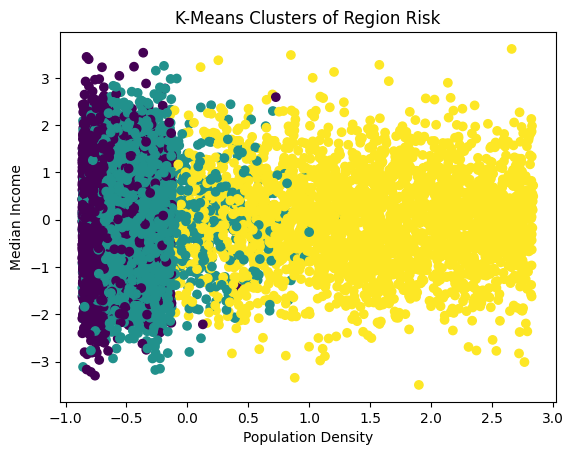

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardize the features for clustering
features = ['population_density', 'median_income', 'elderly_percentage', 'child_percentage',
            'hospitals_per_100k', 'vaccination_rate', 'avg_temperature', 'avg_humidity',
            'annual_rainfall', 'air_quality_index', 'disease_incidents_last_year', 'outbreak_frequency_5years',
            'avg_outbreak_duration', 'daily_commuter_percentage', 'international_travel_freq',
            'public_transport_usage']

X = data[features]
X_scaled = StandardScaler().fit_transform(X)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Visualizing the KMeans Clusters
plt.scatter(data['population_density'], data['median_income'], c=data['kmeans_cluster'], cmap='viridis')
plt.xlabel('Population Density')
plt.ylabel('Median Income')
plt.title('K-Means Clusters of Region Risk')
plt.show()

Heat Maps and Risk Profiles (Risk score across regions)

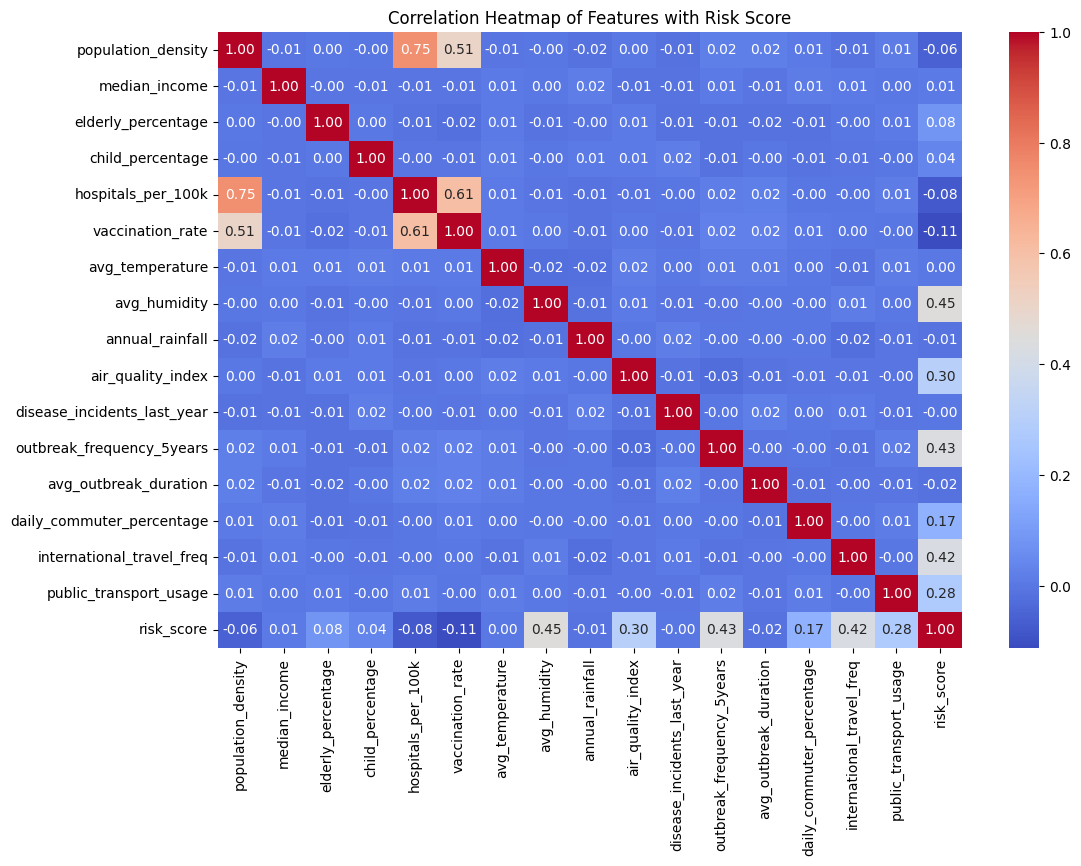

In [ ]:
import seaborn as sns

# Heatmap for risk score distribution across regions (using a correlation matrix as an example)
correlation_matrix = data[features + ['risk_score']].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features with Risk Score')
plt.show()

Identifies high-risk clusters based on a threshold of the risk score and generates actionable recommendations for those regions

In [ ]:
# Identifying high-risk clusters based on the risk score
high_risk_clusters = data[data['risk_score'] > data['risk_score'].quantile(0.75)]

# Creating a DataFrame for high-risk regions and their recommendations
high_risk_regions = high_risk_clusters[['region_id', 'risk_score']].copy()
high_risk_regions['recommendation'] = "Consider targeted vaccination efforts or infrastructure improvement."

# Display the DataFrame as a table
print("High-Risk Regions and Recommendations:")
print(high_risk_regions)

High-Risk Regions and Recommendations:
      region_id  risk_score                                     recommendation
1             2   54.447595  Consider targeted vaccination efforts or infra...
2             3   45.836201  Consider targeted vaccination efforts or infra...
3             4   48.289559  Consider targeted vaccination efforts or infra...
8             9   48.537662  Consider targeted vaccination efforts or infra...
11           12   51.334760  Consider targeted vaccination efforts or infra...
...         ...         ...                                                ...
9986       9987   45.893995  Consider targeted vaccination efforts or infra...
9987       9988   49.196279  Consider targeted vaccination efforts or infra...
9988       9989   44.910113  Consider targeted vaccination efforts or infra...
9993       9994   52.494853  Consider targeted vaccination efforts or infra...
9994       9995   47.611524  Consider targeted vaccination efforts or infra...

[2500 rows x

In [ ]:
# Identifying high-risk clusters based on the risk score
high_risk_clusters = data[data['risk_score'] > data['risk_score'].quantile(0.75)]

# Creating a DataFrame for high-risk regions and their recommendations
high_risk_regions = high_risk_clusters[['region_id', 'risk_score']].copy()
high_risk_regions['recommendation'] = "Consider targeted vaccination efforts or infrastructure improvement."

# Sorting the high-risk regions by risk score in descending order
high_risk_regions_sorted = high_risk_regions.sort_values(by='risk_score', ascending=False)

# Display the top 15 high-risk regions and recommendations
top_15_high_risk_regions = high_risk_regions_sorted.head(15)

# Print the top 15 high-risk regions and their recommendations
print("Top 15 High-Risk Regions and Recommendations:")
print(top_15_high_risk_regions)

Top 15 High-Risk Regions and Recommendations:
      region_id  risk_score                                     recommendation
8158       8159   63.330185  Consider targeted vaccination efforts or infra...
6379       6380   62.109349  Consider targeted vaccination efforts or infra...
3967       3968   61.906869  Consider targeted vaccination efforts or infra...
7211       7212   61.905131  Consider targeted vaccination efforts or infra...
4543       4544   60.311613  Consider targeted vaccination efforts or infra...
368         369   60.173099  Consider targeted vaccination efforts or infra...
6017       6018   60.046806  Consider targeted vaccination efforts or infra...
5962       5963   59.657432  Consider targeted vaccination efforts or infra...
5218       5219   59.638188  Consider targeted vaccination efforts or infra...
9264       9265   59.348988  Consider targeted vaccination efforts or infra...
2102       2103   59.302472  Consider targeted vaccination efforts or infra...
1568  

Risk score on high risk regions and Correlation heat map of key features

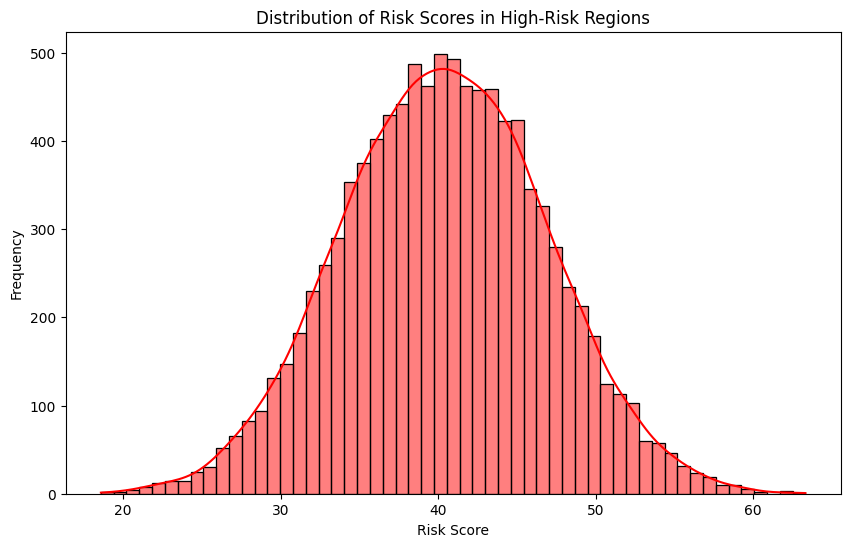

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example threshold for high-risk regions based on risk_score
risk_score_threshold = 0.7  # Modify this threshold based on your data

# Filter the data to get high-risk regions (assuming 'data' is your full DataFrame)
high_risk_data = data[data['risk_score'] >= risk_score_threshold]

# Plot distribution of risk scores in high-risk regions
plt.figure(figsize=(10, 6))
sns.histplot(high_risk_data['risk_score'], kde=True, color='red')
plt.title('Distribution of Risk Scores in High-Risk Regions')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.show()

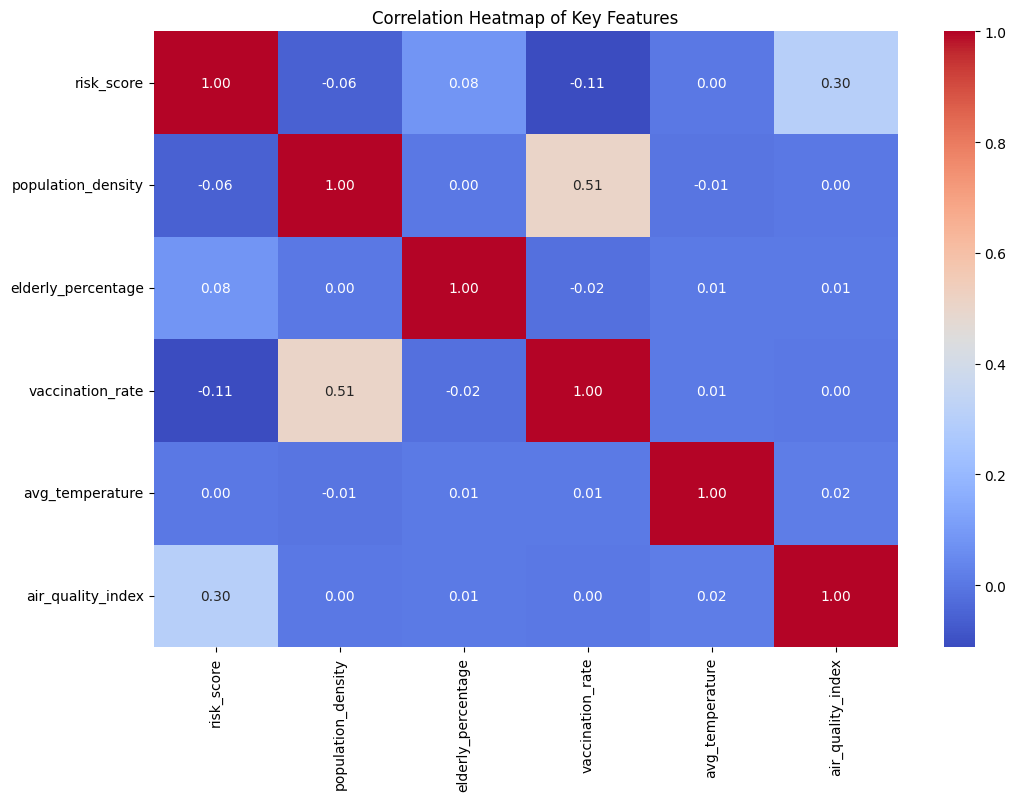

In [ ]:
# Plot correlation heatmap of key features in high-risk regions
plt.figure(figsize=(12, 8))
corr = high_risk_data[['risk_score', 'population_density', 'elderly_percentage', 'vaccination_rate',
                       'avg_temperature', 'air_quality_index']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Key Features')
plt.show()

High-Risk Regions Based on Risk Score

In [ ]:
# Define high-risk regions based on risk_score threshold
risk_score_threshold = 0.7  # Adjust this threshold based on your data
high_risk_data = data[data['risk_score'] >= risk_score_threshold]

# Check the first few rows to verify the data
print(high_risk_data.head())

   region_id  region_type  population_density  median_income  \
0          1            1           -0.458463      -0.252188   
1          2            2            1.342998       0.825290   
2          3            0           -0.764292       0.462251   
3          4            1           -0.627683       1.474029   
4          5            0           -0.775970       1.800547   

   elderly_percentage  child_percentage  hospitals_per_100k  vaccination_rate  \
0           22.367720         18.824620            0.555913          0.104861   
1           16.234222         20.200680            1.311902          0.026129   
2           22.140685         17.759992           -1.290620         -1.872783   
3           23.318447         20.912978           -0.344873          0.337987   
4           12.786629         21.044174           -1.084175         -1.779528   

   healthcare_accessibility_score  avg_temperature  ...  Num_Lab_Procedures  \
0                        1.285971        -0.16913

PERORMANCE SUMMARY OF DIFFERENT CLASSIFICATION MODELS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create data for classifier performance
data = {
    'Metric': ['ROC-AUC Score', 'Accuracy',
               'Class 0 Precision', 'Class 0 Recall', 'Class 0 F1-score',
               'Class 1 Precision', 'Class 1 Recall', 'Class 1 F1-score',
               'Class 2 Precision', 'Class 2 Recall', 'Class 2 F1-score'],

    # Random Forest
    'Random Forest': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],

    # MLP
    'MLP': [0.9995, 0.99, 0.9984, 1.0, 0.9992, 0.9762, 0.9989, 0.9874, 0.9989, 0.9743, 0.9865],

    # Logistic Regression
    'Logistic Regression': [0.9998, 1.0, 0.9995, 1.0, 0.9997, 0.9947, 1.0, 0.9974, 1.0, 0.9942, 0.9971],

    # Naive Bayes
    'Naive Bayes': [0.9980, 0.97, 0.9984, 1.0, 0.9992, 0.9519, 0.9756, 0.9636, 0.9752, 0.9497, 0.9623],

    # KNN
    'KNN': [0.988, 0.98, 0.9989, 1.0, 0.9995, 0.9448, 0.9995, 0.9714, 0.9994, 0.9413, 0.9695],

    # SVM
    'SVM': [0.984, 0.98, 0.9968, 1.0, 0.9984, 0.9593, 1.0, 0.9792, 1.0, 0.9549, 0.9769]
}

# Create a DataFrame from the data
df_performance = pd.DataFrame(data)

# Display the DataFrame
print(df_performance)

               Metric  Random Forest     MLP  Logistic Regression  \
0       ROC-AUC Score            1.0  0.9995               0.9998   
1            Accuracy            1.0  0.9900               1.0000   
2   Class 0 Precision            1.0  0.9984               0.9995   
3      Class 0 Recall            1.0  1.0000               1.0000   
4    Class 0 F1-score            1.0  0.9992               0.9997   
5   Class 1 Precision            1.0  0.9762               0.9947   
6      Class 1 Recall            1.0  0.9989               1.0000   
7    Class 1 F1-score            1.0  0.9874               0.9974   
8   Class 2 Precision            1.0  0.9989               1.0000   
9      Class 2 Recall            1.0  0.9743               0.9942   
10   Class 2 F1-score            1.0  0.9865               0.9971   

    Naive Bayes     KNN     SVM  
0        0.9980  0.9880  0.9840  
1        0.9700  0.9800  0.9800  
2        0.9984  0.9989  0.9968  
3        1.0000  1.0000  1.0000  
4

**Key Insights (Perfomrance Analysis):**
Best Classifier: Random Forest performs best overall, with perfect accuracy and F1-scores across all classes.
MLP and Logistic Regression also perform excellently, with very high ROC-AUC scores and near-perfect metrics.
Naive Bayes, KNN, and SVM show slightly lower accuracy but still demonstrate good performance across classes, especially in terms of precision and recall for Class 0 (the most important class in many cases).

**Actionable Insights (Based on Performance Outcomes):**
For applications requiring the highest accuracy and model confidence, the Random Forest classifier is the best choice due to its perfect performance across all metrics.
If computational efficiency is a concern and high performance is still needed, MLP or Logistic Regression would be the next best choices.
Naive Bayes, KNN, and SVM provide strong performance but may struggle with certain class imbalances and slightly lower overall accuracy compared to the other models.

**Key Insights from Cluster Analysis:**

Cluster analysis identified regions at higher outbreak risk, highlighting the impact of vaccination rates, population density, and environmental factors like air quality.
High-risk areas often have lower vaccination rates and higher population densities, with varying environmental conditions affecting risk.

**Potential Limitations:**

Data Quality: Missing data and incomplete variables can affect the model’s accuracy.
Model Assumptions: Homogeneity within clusters may not always apply, and key variables might be overlooked.
Temporal Factors: Historical data may not reflect current trends in health dynamics.

**Continuous Model Improvement:**

Incorporate additional socio-economic and real-time data.
Use adaptive clustering methods and interpretable models to enhance accuracy and relevance.
Regular validation and expert feedback are necessary for continuous model refinement.